# Clustering on simulated trajectories

This script simulates a user trajectory and GPS pings produced at different frequencies. We generate synthetic trajectories simulating three stays and movement between them for a given user. We assume that the roaming distance in the first and second location is σ1 = 3x30 meters, which, together with an assumed horizontal accuracy of ε = 10 meters, which we simulate by sampling pings from a normal N ((0, 0), (σ1 + ε)2I ) at a given hourly frequency. The user is then assumed to move x = 1000 meters from (0,0) to (1000, 0) over the span of T = 15 minutes (4km/h), so, with the same horizontal accuracy, we can simulate this behavior by sampling pings with a given ping frequency from the interval t ∈ [0, T ] from a normal N((x∗t/T,0),ε2I). We assume there is a stay of 3 hours in the second location, which is also larger, captured by a roaming parameter of σ2 = 120, which we simulate by sampling pings with a given frequency from a normal
N ((x, 0), (σ2 + ε)2I ).Pings are sampled uniformly from the 5.5 hour window at three different frequencies: “low freq.” sampling 2 pings an hour, “medium freq.” sampling 5 pings an hour, and “high freq.” sampling 25 pings an hour. We apply two parameterizations of our “DBScan” algorithm: “fine” with parameters given by distance threshold d = 30meters, time threshold t = 120 minutes, and minimum number of points N = 4; and “coarse” with parameters given by distance threshold d = 100meters, time threshold t = 360 minutes, and minimum number of points N = 3.

In [1]:
#pip install tick

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

#import pdb

### Trajectory Simulation
We simulate a user's trajectory using Brownian motion and sample from this trajectory via a Hawkes process to obtain sparse pings. 

Define trajectory stays (center, radius, duration) and moves (duration) between stays.

In [2]:
import trajectory_simulation as tsim

mu_0 = np.array([-100,110])
mu_1 = np.array([0,-110])
mu_2 = np.array([950,0])

sig_1 = 30
sig_2 = 60

eps = 8

var_1 = np.identity(2)*(sig_1 + eps)**2
var_2 = np.identity(2)*(sig_2 + eps)**2
var_3 = np.identity(2)*eps**2

stays = [(mu_0, 3*sig_1, 60), (mu_1, 3*sig_1, 60), (mu_2, 3*sig_2, 180)]
moves = [5, 15]

Animation of the (pre-sampled) simulated trajectory.

In [3]:
from matplotlib.animation import FuncAnimation, PillowWriter

data = tsim.simulate_traj(stays, moves, 110)
fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, 3 * sig_1, color='gray', alpha=0.2),
           Circle(mu_1, 3 * sig_1, color='gray', alpha=0.2),
           Circle(mu_2, 3 * sig_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

ax.set_xlim((-250, 1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(True)

line, = ax.plot([], [], color='blue', alpha=0.1)
scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
time_text = ax.text(0.35, 0.85, '', transform=ax.transAxes)

def update(i):
    line.set_data(data['x'][:i], data['y'][:i])
    scatter.set_offsets(data[['x', 'y']][:i])
    time_text.set_text(data['local_timestamp'][i].strftime('%Y-%m-%d %H:%M:%S'))
    return line, scatter

#anim = FuncAnimation(fig, update, frames=len(data), interval=50, blit=True)
#anim.save('trajectory_animation.gif', writer=PillowWriter(fps=20))
#plt.close(fig)

Animation of the sampled simulated trajectory.

In [4]:
data = tsim.simulate_traj(stays, moves, 110)
data = tsim.sample_traj(data, 0, 110)
fig, ax = plt.subplots(figsize=(9, 3))

patches = [Circle(mu_0, 3 * sig_1, color='gray', alpha=0.2),
           Circle(mu_1, 3 * sig_1, color='gray', alpha=0.2),
           Circle(mu_2, 3 * sig_2, color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

ax.set_xlim((-250, 1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(True)

points, = ax.plot([], [], 'o', color='black', alpha=0.5)
time_text = ax.text(0.35, 0.85, '', transform=ax.transAxes)

timestamps_to_plot = pd.date_range(start='2022-01-01 00:00:00', end='2022-01-01 05:19:00', freq='min')
points_dict = {str(timestamp): data[(data['local_timestamp'] >= timestamp) & 
                                    (data['local_timestamp'] < timestamp + pd.Timedelta(seconds=1))]
               for timestamp in timestamps_to_plot}

def update(current_time):
    current_data = data[data['local_timestamp'] <= current_time]
    if not current_data.empty:
        points.set_data(current_data['x'], current_data['y'])
    time_text.set_text(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    return points,

#anim = FuncAnimation(fig, update, frames=timestamps_to_plot, interval=50, repeat=False)
#anim.save('sampling_animation.gif', writer=PillowWriter(fps=20))
#plt.close(fig)

Examples of sampled trajectories.

Seed: 128
Seed: 489
Seed: 165
Seed: 592
Seed: 326
Seed: 740
Seed: 701
Seed: 466


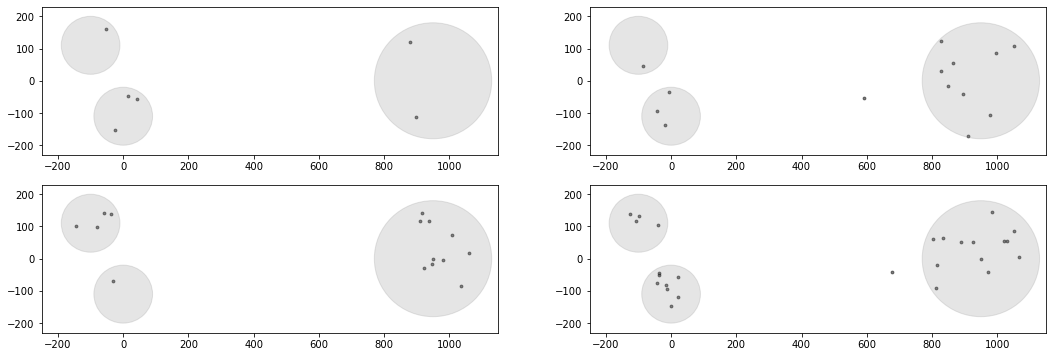

In [5]:
%matplotlib inline

fig, axes = plt.subplots(2,2,figsize=(18, 6))

for ax in axes.flatten():
    
    data = tsim.simulate_traj(stays, moves)
    data = tsim.sample_traj(data, 0)
    
    patches =  [Circle(mu_0, 3*(sig_1), color='gray', alpha=0.2),
                Circle(mu_1, 3*(sig_1), color='gray', alpha=0.2),
                Circle(mu_2, 3*(sig_2), color='gray', alpha=0.2)]

    for p in patches:
        ax.add_patch(p)

    #ax.plot(data.x, data.y, color='blue', alpha=0.1) 
    ax.scatter(data.x, data.y, s=8, color='black', alpha=0.5)
    ax.set_xlim((-250,1150))
    ax.set_ylim((-230, 230))
    ax.get_yaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    
plt.show()

## Test clustering and plotting: DBSCAN

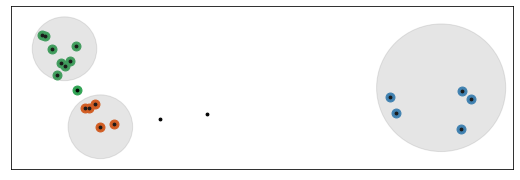

In [6]:
import stop_detection as sd

data = tsim.simulate_traj(stays, moves, 110)
data = tsim.sample_traj(data, 0, 110)
cluster_pings = sd.dbscan_patches(data, 0, 110)
fig, ax = plt.subplots(figsize=(9, 3))

patches =  [Circle(mu_0, 3*(sig_1), color='gray', alpha=0.2),
            Circle(mu_1, 3*(sig_1), color='gray', alpha=0.2),
            Circle(mu_2, 3*(sig_2), color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

for i, pings in enumerate(cluster_pings):
    col = cm.tab20c(i/5)
    ax.scatter(pings.x, pings.y, s=80, color=col, alpha=1)    
    
ax.scatter(data.x, data.y, s=8, color='black', alpha=1)
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

2x2 plots showing different configurations

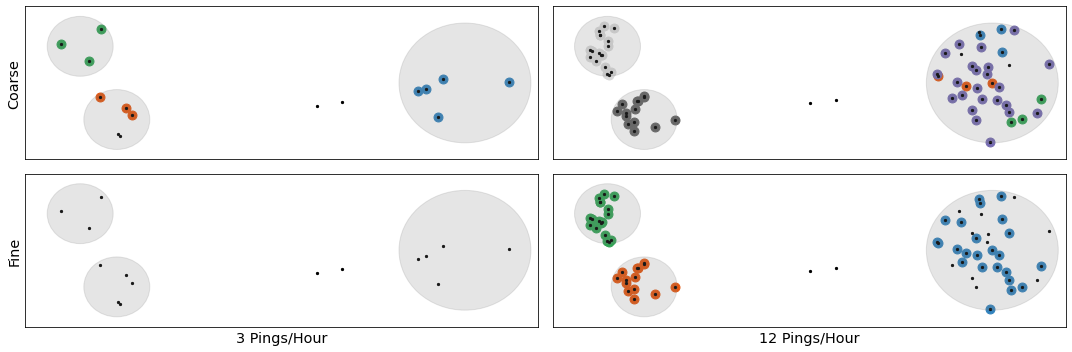

In [7]:
fig, axes = plt.subplots(2,2, figsize=(15, 5))

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        seed = [200,300][j]
        #df, cluster_pings = simulate_clusters(i,j,[520,110][j])
        df = tsim.simulate_traj(stays, moves, seed)
        df = tsim.sample_traj(df, j, seed)
        cluster_pings = sd.dbscan_patches(df, i, seed)

        patches =  [Circle(mu_0, 3*(sig_1), color='gray', alpha=0.2),
                    Circle(mu_1, 3*(sig_1), color='gray', alpha=0.2),
                    Circle(mu_2, 3*(sig_2), color='gray', alpha=0.2)]
        for p in patches:
            ax.add_patch(p)
        
        for idx, data in enumerate(cluster_pings):
            col = cm.tab20c(idx/5)
            ax.scatter(data.x, data.y, s=80, color=col, alpha=1)          

        ax.scatter(df.x, df.y, s=5, color='black', alpha=1)
        ax.set_xlim((-250,1150))
        ax.set_ylim((-230, 230))
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0,0].set_ylabel('Coarse', fontsize='x-large')
axes[1,0].set_ylabel('Fine', fontsize='x-large')
axes[1,0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1,1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
#plt.savefig("../covid-clustering/plots/{}.svg".format("synthetic_robustness"))
plt.show()

## Test clustering and plotting: Lachesis

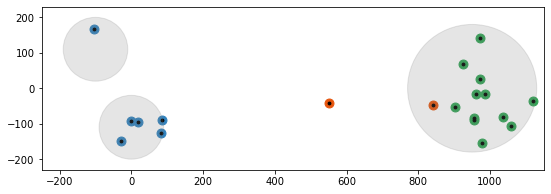

In [8]:
data = tsim.simulate_traj(stays, moves, 400)
data = tsim.sample_traj(data, 0, 230)
cluster_pings = sd.lachesis_patches(data, 0)
fig, ax = plt.subplots(figsize=(9, 3))

patches =  [Circle(mu_0, 3*(sig_1), color='gray', alpha=0.2),
            Circle(mu_1, 3*(sig_1), color='gray', alpha=0.2),
            Circle(mu_2, 3*(sig_2), color='gray', alpha=0.2)]

for p in patches:
    ax.add_patch(p)

for i, pings in enumerate(cluster_pings):
    col = cm.tab20c(i/5)
    ax.scatter(pings.x, pings.y, s=80, color=col, alpha=1)    
    
ax.scatter(data.x, data.y, s=8, color='black', alpha=1)
ax.set_xlim((-250,1150))
ax.set_ylim((-230, 230))
ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(True)

plt.show()

2x2 plots showing different configurations

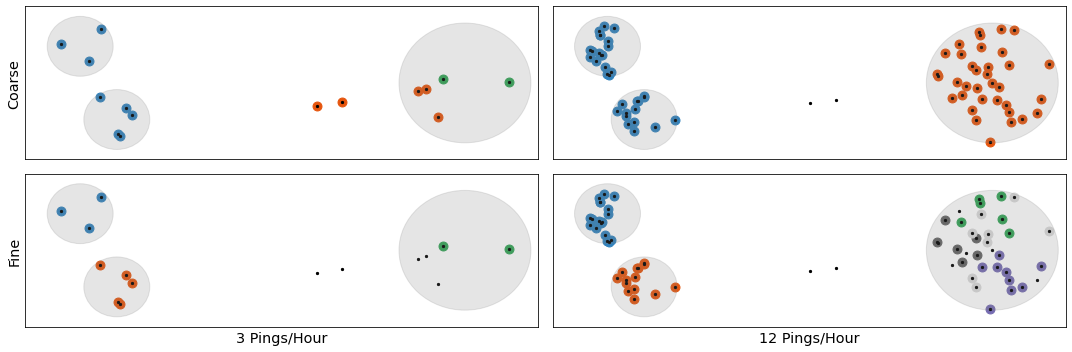

In [9]:
fig, axes = plt.subplots(2,2, figsize=(15, 5))

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        seed = [200,300][j]
        df = tsim.simulate_traj(stays, moves, seed)
        df = tsim.sample_traj(df, j, seed)
        cluster_pings = sd.lachesis_patches(df, i)

        patches =  [Circle(mu_0, 3*(sig_1), color='gray', alpha=0.2),
                    Circle(mu_1, 3*(sig_1), color='gray', alpha=0.2),
                    Circle(mu_2, 3*(sig_2), color='gray', alpha=0.2)]
        for p in patches:
            ax.add_patch(p)
        
        for idx, data in enumerate(cluster_pings):
            col = cm.tab20c(idx/5)
            ax.scatter(data.x, data.y, s=80, color=col, alpha=1)          

        ax.scatter(df.x, df.y, s=5, color='black', alpha=1)
        ax.set_xlim((-250,1150))
        ax.set_ylim((-230, 230))
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0,0].set_ylabel('Coarse', fontsize='x-large')
axes[1,0].set_ylabel('Fine', fontsize='x-large')
axes[1,0].set_xlabel('3 Pings/Hour', fontsize='x-large')
axes[1,1].set_xlabel('12 Pings/Hour', fontsize='x-large')

plt.tight_layout()
#plt.savefig("../covid-clustering/plots/{}.svg".format("synthetic_robustness"))
plt.show()